In [1]:
import torch
import torchvision
import numpy as np
from copy import deepcopy
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
### Hyperparameters
val_split = 0.1
unlabelled_size = 0.99
lr = 0.0005
batch_size = 64
num_epochs = 100
label_iterations = 20

In [3]:
### Setup MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
val_dataset = deepcopy(train_dataset)


In [5]:
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
indexes = torch.randperm(len(train_dataset)).tolist()
# Define validation set
indexes_val = indexes[train_size:]
val_dataset.targets = val_dataset.targets[indexes_val]
val_dataset.data = val_dataset.data[indexes_val]
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [6]:
# Define training set
indexes_train = indexes[:train_size]
train_dataset.targets = train_dataset.targets[indexes_train]
train_dataset.data = train_dataset.data[indexes_train]

In [7]:
# Split training data into labelled and unlabelled
unlabelled_size = int(unlabelled_size * len(train_dataset))
indexes_train = torch.randperm(len(train_dataset)).tolist()  # Redefine indexes_train
unlabbelled_dataset = deepcopy(train_dataset)
unlabbelled_dataset.targets = unlabbelled_dataset.targets[indexes_train[:unlabelled_size]]
unlabbelled_dataset.data = unlabbelled_dataset.data[indexes_train[:unlabelled_size]]
train_dataset.targets = train_dataset.targets[indexes_train[unlabelled_size:]]
train_dataset.data = train_dataset.data[indexes_train[unlabelled_size:]]
unlabbelled_dataset.targets = unlabbelled_dataset.targets
unlabbelled_dataset.data = unlabbelled_dataset.data
start_train_dataset = deepcopy(train_dataset)  # Save for baseline
start_unlabbelled_dataset = deepcopy(unlabbelled_dataset)  # Save for baseline

In [8]:
def transfer_unlabelled_to_labeled(unlabbelled_dataset, train_dataset, indexes):
    # Convert indexes to boolean mask
    indexes = torch.tensor([i in indexes for i in range(len(unlabbelled_dataset.targets))])
    
    train_dataset.targets = torch.cat([train_dataset.targets, unlabbelled_dataset.targets[indexes]])
    train_dataset.data = torch.cat([train_dataset.data, unlabbelled_dataset.data[indexes]])
    unlabbelled_dataset.targets = unlabbelled_dataset.targets[~indexes]
    unlabbelled_dataset.data = unlabbelled_dataset.data[~indexes]

    return train_dataset, unlabbelled_dataset

In [9]:
def validate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [10]:
# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Modify input layer to accept 1 channel
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model_parameters = deepcopy(model.state_dict())
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

c:\Users\soere\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\soere\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, val_interval=1):
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % val_interval == 0:
            val_accuracy = validate_model(model, val_loader, device)
            accuracies.append(val_accuracy)
            print(f'Epoch {epoch + 1}, Accuracy: {val_accuracy:.2f}%')
    return accuracies

In [12]:
def label_iteration(model, train_dataset, unlabelled_dataset, device, top_frac=0.01):
    # Use model to label all images in validation set
    model.eval()
    predictions = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader):
            images = images.to(device)
            outputs = model(images).softmax(dim=1)
            predictions.extend(outputs.detach().cpu().numpy())

    predictions = torch.tensor(predictions)
    # Find top % of images with lowest top-confidence
    top_percent = int(top_frac * len(predictions))
    _, top_indices = predictions.max(-1)[0].topk(top_percent, largest=False)
    print(f"Adding {len(top_indices)} images to training set")
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, top_indices)
    
    return train_dataset, unlabelled_dataset

In [13]:
## Run active learning
datapoint_list = []
accuracy_list = []
for i in range(label_iterations):
    print(i)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.load_state_dict(model_parameters)  # Important to reset the model each time
    accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
    datapoint_list.append(len(train_dataset))
    accuracy_list.append(accuracies)
    if i < label_iterations - 1:
        train_dataset, unlabbelled_dataset = label_iteration(model, train_dataset, unlabbelled_dataset, device, top_frac=0.001)

0


 11%|█         | 11/100 [00:03<00:39,  2.28it/s]

Epoch 10, Accuracy: 90.63%


 21%|██        | 21/100 [00:06<00:34,  2.30it/s]

Epoch 20, Accuracy: 91.02%


 31%|███       | 31/100 [00:09<00:30,  2.27it/s]

Epoch 30, Accuracy: 91.07%


 41%|████      | 41/100 [00:12<00:25,  2.33it/s]

Epoch 40, Accuracy: 91.20%


 51%|█████     | 51/100 [00:15<00:23,  2.11it/s]

Epoch 50, Accuracy: 91.32%


 61%|██████    | 61/100 [00:18<00:17,  2.23it/s]

Epoch 60, Accuracy: 91.27%


 71%|███████   | 71/100 [00:21<00:12,  2.31it/s]

Epoch 70, Accuracy: 91.28%


 81%|████████  | 81/100 [00:24<00:08,  2.31it/s]

Epoch 80, Accuracy: 91.55%


 91%|█████████ | 91/100 [00:27<00:03,  2.31it/s]

Epoch 90, Accuracy: 91.35%


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]


Epoch 100, Accuracy: 91.47%


100%|██████████| 836/836 [00:14<00:00, 57.61it/s]
C:\Users\soere\AppData\Local\Temp\ipykernel_14528\1405331811.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  predictions = torch.tensor(predictions)


Adding 53 images to training set
1


 11%|█         | 11/100 [00:03<00:40,  2.21it/s]

Epoch 10, Accuracy: 92.95%


 21%|██        | 21/100 [00:06<00:35,  2.20it/s]

Epoch 20, Accuracy: 93.58%


 30%|███       | 30/100 [00:09<00:40,  1.75it/s]

Epoch 30, Accuracy: 94.45%


 41%|████      | 41/100 [00:13<00:26,  2.20it/s]

Epoch 40, Accuracy: 94.43%


 51%|█████     | 51/100 [00:16<00:22,  2.19it/s]

Epoch 50, Accuracy: 94.47%


 61%|██████    | 61/100 [00:19<00:17,  2.17it/s]

Epoch 60, Accuracy: 94.65%


 70%|███████   | 70/100 [00:22<00:17,  1.72it/s]

Epoch 70, Accuracy: 94.72%


 81%|████████  | 81/100 [00:26<00:08,  2.21it/s]

Epoch 80, Accuracy: 94.65%


 91%|█████████ | 91/100 [00:29<00:04,  2.21it/s]

Epoch 90, Accuracy: 94.57%


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]

Epoch 100, Accuracy: 94.47%


In [14]:
# Add baseline accuracy (no active learning)
n_datapoints = len(train_dataset) - len(start_train_dataset)
model.load_state_dict(model_parameters)
# We reuse the initial training set to reduce run to run variance
train_dataset.data = torch.cat([start_train_dataset.data, start_unlabbelled_dataset.data[:n_datapoints]])
train_dataset.targets = torch.cat([start_train_dataset.targets, start_unlabbelled_dataset.targets[:n_datapoints]])

In [15]:
# Train model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
baseline_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)

 11%|█         | 11/100 [00:03<00:39,  2.23it/s]

Epoch 10, Accuracy: 92.22%


 21%|██        | 21/100 [00:06<00:35,  2.21it/s]

Epoch 20, Accuracy: 93.95%


 31%|███       | 31/100 [00:09<00:32,  2.13it/s]

Epoch 30, Accuracy: 94.33%


 41%|████      | 41/100 [00:12<00:26,  2.22it/s]

Epoch 40, Accuracy: 94.33%


 51%|█████     | 51/100 [00:16<00:22,  2.22it/s]

Epoch 50, Accuracy: 94.25%


 61%|██████    | 61/100 [00:19<00:17,  2.21it/s]

Epoch 60, Accuracy: 94.43%


 71%|███████   | 71/100 [00:22<00:13,  2.22it/s]

Epoch 70, Accuracy: 94.53%


 81%|████████  | 81/100 [00:25<00:08,  2.22it/s]

Epoch 80, Accuracy: 94.38%


 91%|█████████ | 91/100 [00:28<00:04,  2.21it/s]

Epoch 90, Accuracy: 94.28%


100%|██████████| 100/100 [00:31<00:00,  3.15it/s]

Epoch 100, Accuracy: 94.37%


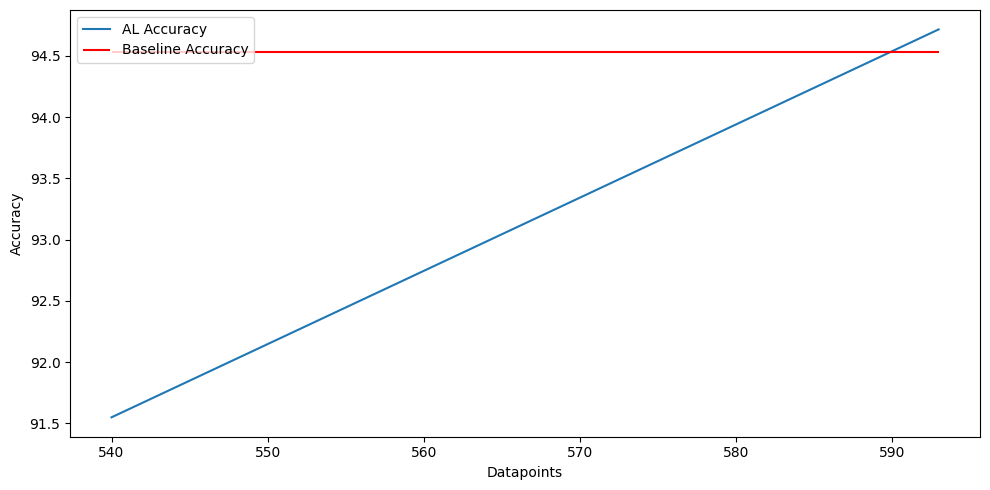

In [16]:
# Plot the accuracy
datapoints = np.array(datapoint_list)
accuracies = np.array(accuracy_list).max(-1)
plt.figure(figsize=(10, 5))
plt.plot(datapoints, accuracies, label='AL Accuracy')
plt.hlines(max(baseline_accuracy), min(datapoints), max(datapoints), label='Baseline Accuracy', color='red')
plt.xlabel('Datapoints')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('figs/accuracy.png')
plt.show()